In [1]:
"""
SEE: https://github.com/sudoswap/lssvm/blob/main/src/LSSVMPair.sol
Events to query for are:
  1. SwapNFTInPair()
    - emitted by LSSVMPair.swapNFTsForToken()  (sell order)
    - has no data so need to look at Transfer event for volume
  2. SwapNFTOutPair()
    - emitted by LSSVMPair.swapTokenForAnyNFTs() (buy order)
    - has no data so need to look at Transfer event for volume
  3. SpotPriceUpdate(uint128 newSpotPrice)
    - emitted by LSSVMPair on spot price changes: use to track price changes
"""
# switch to sudo-ape wd first for ape project to work properly
import os
from pathlib import Path

if Path(*Path(os.getcwd()).parts[-2:]) == Path('sudo-ape/notebook'):
    os.chdir('..')

In [3]:
import pandas as pd
import typing as tp

from ape import accounts, chain, Contract, networks, project

In [4]:
networks.parse_network_choice('ethereum:mainnet:alchemy').__enter__()

<alchemy chain_id=1>

In [5]:
current_block = chain.blocks[-1].number
current_block

15466515

In [40]:
start_block = 14645816  # pair factory deployment
start_block

14645816

In [6]:
sudo_router = Contract("0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329")
sudo_router

<LSSVMRouter 0x2B2e8cDA09bBA9660dCA5cB6233787738Ad68329>

In [7]:
sudo_factory = Contract("0xb16c1342E617A5B6E4b631EB114483FDB289c0A4")
sudo_factory

<LSSVMPairFactory 0xb16c1342E617A5B6E4b631EB114483FDB289c0A4>

In [8]:
sudo_factory.NewPair

NewPair(address poolAddress)

In [9]:
# use address of top xmons pool to check is pool thru factory
sudo_factory.isPair("0x5caf332dca4e6c9e69d52f320c21e74845353db0", 0)

True

In [12]:
sudo_pair_xmons = Contract("0x5caf332dca4e6c9e69d52f320c21e74845353db0")
sudo_pair_xmons

<LSSVMPair 0x5caF332DcA4e6C9E69d52F320c21e74845353db0>

In [57]:
# TRADE pool type
sudo_pair_xmons.poolType()

2

In [13]:
# utility functions to unfold event arguments into separate columns
def unfold_event_args(key: str, event_args: dict) -> tp.Any:
    return event_args[key]

def unfold(df: pd.DataFrame):
    for key in df.iloc[-1]['event_arguments'].keys():
        df[key] = df['event_arguments'].apply(lambda ev: unfold_event_args(key, ev))

In [51]:
%time query_pairs = sudo_factory.NewPair.query("*", start_block=start_block)
query_pairs

CPU times: user 40.2 s, sys: 5.41 s, total: 45.6 s
Wall time: 5min 44s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149
...,...,...,...,...,...,...,...,...
28742,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x2719012FFAB7Bc1a70Ca5D83045...,0xb39e9c340f1d7d79203f5d8d83a164dc3499b2aad1bc...,15466464,0x70b6d6fc88e53d739b0576fe0268cfd10b1561555f0f...,89,47
28743,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x044D41De4247f006A2819F2B6E7...,0x5ce949dc4a50295f3fde89cf66f25a324c4ca61580d4...,15466478,0x6775da35f6819e3ba3221b448f19389d8940e472bce1...,28,22
28744,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0864A804165B0772d90eF6aF98a...,0xb000d46205246bf4e82aaec06a426c126bf13c5be733...,15466496,0x84f245c9d27be0c67652556b99fcaa64e254d6d3911e...,39,15
28745,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x48b5059d79d1D2EfcffE410095F...,0x47d2ad6a0accfa4ffc2125c3b2fe8ff4af32f49f782d...,15466562,0x0bdedfc6f28343d2acfa188b393a4bea5de99612269e...,469,145


In [52]:
unfold(query_pairs)

In [72]:
# ~29k pools deployed already over last 4 months
query_pairs

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9,0x08142348E6BBf233002b81047bc2f27026af10A5
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37,0x518b7160990AD19dcfF0Ba028e245fA616b44F5E
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117,0x351E40e39ae7D0d60Dc283485bC627891Ec1D00E
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149,0x866C5c02dC07EE37146c4874d704D3603bF5D950
...,...,...,...,...,...,...,...,...,...
28742,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x2719012FFAB7Bc1a70Ca5D83045...,0xb39e9c340f1d7d79203f5d8d83a164dc3499b2aad1bc...,15466464,0x70b6d6fc88e53d739b0576fe0268cfd10b1561555f0f...,89,47,0x2719012FFAB7Bc1a70Ca5D8304580C36C778B51B
28743,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x044D41De4247f006A2819F2B6E7...,0x5ce949dc4a50295f3fde89cf66f25a324c4ca61580d4...,15466478,0x6775da35f6819e3ba3221b448f19389d8940e472bce1...,28,22,0x044D41De4247f006A2819F2B6E77aCcbCfFA576a
28744,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0864A804165B0772d90eF6aF98a...,0xb000d46205246bf4e82aaec06a426c126bf13c5be733...,15466496,0x84f245c9d27be0c67652556b99fcaa64e254d6d3911e...,39,15,0x0864A804165B0772d90eF6aF98aB2Bb8697662d3
28745,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x48b5059d79d1D2EfcffE410095F...,0x47d2ad6a0accfa4ffc2125c3b2fe8ff4af32f49f782d...,15466562,0x0bdedfc6f28343d2acfa188b393a4bea5de99612269e...,469,145,0x48b5059d79d1D2EfcffE410095Fe834F095C0C2f


In [79]:
# NewPair events don't give the NFT collection address; only give the pair address
# query for those collection addresses so can focus on only one collection at a time for now
def get_pair_specifics(key: str, x: pd.Series) -> tp.Any:
    addr = x['poolAddress']
    pair = project.LSSVMPair.at(addr)
    val = getattr(pair, key)()
    return val

# TODO: %time query_pairs['nft'] = query_pairs.apply(lambda x: get_pair_specifics('nft', x), axis=1)

In [80]:
query_pairs

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,poolAddress
0,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x08142348E6BBf233002b81047bc...,0xba75dd0b017667074a1ed080571fee06b3cea5444f25...,14650748,0xf63250e045af2d83fca5535fe3738deffd3c6f17f93b...,15,9,0x08142348E6BBf233002b81047bc2f27026af10A5
1,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x518b7160990AD19dcfF0Ba028e2...,0x7e33fe2f08ee09a339b127c8658a892600637da3448d...,14652189,0x4b0de468eecdfea07b64168655f129d43d8e56f01f42...,41,37,0x518b7160990AD19dcfF0Ba028e245fA616b44F5E
2,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x351E40e39ae7D0d60Dc283485bC...,0x230624db7d760f3ad189bdebb431ef74b6cd899855d6...,14652199,0x572e74e542e87e141a2176725d7b216133bd0d13dcf5...,150,117,0x351E40e39ae7D0d60Dc283485bC627891Ec1D00E
3,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0636a6Bd07dDBEA28a3cc63353e...,0xff03f1a4956f878f1bd42a6dfa2ec18165822cde3d15...,14652223,0x877d4993fe635aaaea71fa3c8bb8c705d67f86559c3e...,142,108,0x0636a6Bd07dDBEA28a3cc63353ea725e8cE509e2
4,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x866C5c02dC07EE37146c4874d70...,0x0c2b148a424bb8f25f32ca3ded2c87704cb73ab5b65b...,14662427,0x8f687e0ea159efeb37fd7e65ec00a008e6b96cc1b7ee...,171,149,0x866C5c02dC07EE37146c4874d704D3603bF5D950
...,...,...,...,...,...,...,...,...,...
28742,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x2719012FFAB7Bc1a70Ca5D83045...,0xb39e9c340f1d7d79203f5d8d83a164dc3499b2aad1bc...,15466464,0x70b6d6fc88e53d739b0576fe0268cfd10b1561555f0f...,89,47,0x2719012FFAB7Bc1a70Ca5D8304580C36C778B51B
28743,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x044D41De4247f006A2819F2B6E7...,0x5ce949dc4a50295f3fde89cf66f25a324c4ca61580d4...,15466478,0x6775da35f6819e3ba3221b448f19389d8940e472bce1...,28,22,0x044D41De4247f006A2819F2B6E77aCcbCfFA576a
28744,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x0864A804165B0772d90eF6aF98a...,0xb000d46205246bf4e82aaec06a426c126bf13c5be733...,15466496,0x84f245c9d27be0c67652556b99fcaa64e254d6d3911e...,39,15,0x0864A804165B0772d90eF6aF98aB2Bb8697662d3
28745,NewPair,0xb16c1342E617A5B6E4b631EB114483FDB289c0A4,{'poolAddress': '0x48b5059d79d1D2EfcffE410095F...,0x47d2ad6a0accfa4ffc2125c3b2fe8ff4af32f49f782d...,15466562,0x0bdedfc6f28343d2acfa188b393a4bea5de99612269e...,469,145,0x48b5059d79d1D2EfcffE410095Fe834F095C0C2f


In [17]:
sudo_pair_xmons.SpotPriceUpdate

SpotPriceUpdate(uint128 newSpotPrice)

In [41]:
# get start block from query_pairs IF query can't handle when start_block < contract creation block (it can, woot)
%time query_prices_xmons = sudo_pair_xmons.SpotPriceUpdate.query('*', start_block=start_block)
query_prices_xmons

CPU times: user 31.7 s, sys: 5.33 s, total: 37.1 s
Wall time: 5min 12s


,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59
...,...,...,...,...,...,...,...,...
59,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x9d14895b06d4fa818d5c71df6001037b1286aed68fdb...,15459298,0xd5fd59ddec2d3623ff85677d868394edf81f2caf3d55...,36,27
60,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0x4f9caf401cd03e10d90f2c4a13f066f2d807fa07a155...,15459389,0x2833d689166e32cd3f7c32afad0ce57ace9ee788f3f1...,33,18
61,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x2946f9b515e1b1144a2a2a7de75e111bdc1700485e16...,15460128,0xbe6bdd7ff1c6ead20430c3ca591031e3cab7165b492d...,79,52
62,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xc5dd46e77a6a15f76f76b34bebc89c57a0a7436febb7...,15460372,0x46a34b7810110fe9171b49155170a0a8af02658675e5...,190,127


In [43]:
unfold(query_prices_xmons)

In [46]:
# convert spot price from units of wei to units of ETH
query_prices_xmons['newSpotPrice'] = query_prices_xmons['newSpotPrice'] / 1e18

In [47]:
# only 64 price updates for this pool over the last 44 days since deployed (not much)
query_prices_xmons

,event_name,contract_address,event_arguments,transaction_hash,block_number,block_hash,log_index,transaction_index,newSpotPrice
0,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x195069bfc2a5e1ee78ee3cd8114fdfce8c0d482036d3...,15198846,0xd3b29ce639c43280c2a194b638e07a5e1541824210aa...,54,37,9.07767
1,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0xe6d9db380c0b7b3d9923ac18e1a920c64a60ef0e2f2e...,15199800,0x420f1997f04b486a8ed114b32337abb0f8722e82ef1f...,79,82,11.57767
2,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14077669902912621000},0x85212d1b00c2c505bda6b7a56d2b1f2a893646a0d55b...,15203036,0x0e89e72ff162aa1b1ec18cdad70825885d7c0884f425...,233,138,14.07767
3,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 11577669902912621000},0x414ea41198833a399a68c9b66456047bc6dd349330d7...,15208415,0x36dce9b484abf8db83699dabf5d63cbca4b9f68cc7e2...,120,56,11.57767
4,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 9077669902912621000},0x28758b8d0ad21047a93b75089e210e0ca85f652842ef...,15218330,0x10112e7b56853191c7e46d36f0cca7431be567982f5c...,73,59,9.07767
...,...,...,...,...,...,...,...,...,...
59,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x9d14895b06d4fa818d5c71df6001037b1286aed68fdb...,15459298,0xd5fd59ddec2d3623ff85677d868394edf81f2caf3d55...,36,27,17.330097
60,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0x4f9caf401cd03e10d90f2c4a13f066f2d807fa07a155...,15459389,0x2833d689166e32cd3f7c32afad0ce57ace9ee788f3f1...,33,18,14.830097
61,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 17330097087378640000},0x2946f9b515e1b1144a2a2a7de75e111bdc1700485e16...,15460128,0xbe6bdd7ff1c6ead20430c3ca591031e3cab7165b492d...,79,52,17.330097
62,SpotPriceUpdate,0x5caF332DcA4e6C9E69d52F320c21e74845353db0,{'newSpotPrice': 14830097087378640000},0xc5dd46e77a6a15f76f76b34bebc89c57a0a7436febb7...,15460372,0x46a34b7810110fe9171b49155170a0a8af02658675e5...,190,127,14.830097


<AxesSubplot:xlabel='block_number', ylabel='newSpotPrice'>

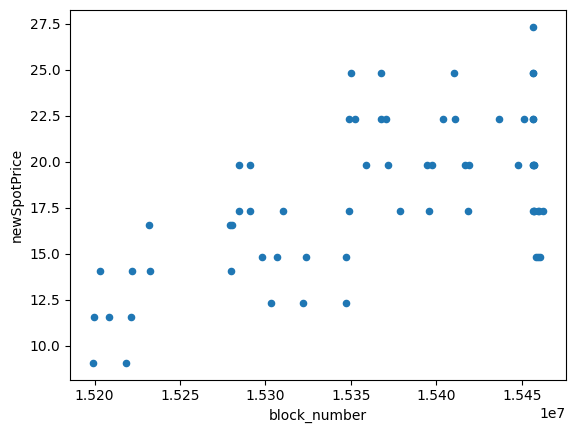

In [50]:
query_prices_xmons.plot(x='block_number', y='newSpotPrice', kind='scatter')